### Model Evaluation

In this script we add the code to evaluate the models of the different proposed models. You will find here:

1. The preprocessing process of the data
2. The evaluation method: cross-validation with 2 groups for testing, 9 for training
3. The Mean Confusion Matrix
4. Precission and Recall

In order to evaluate a model, copy and paste the .h5 file of the model into the 'Evaluation' folder inside the 'models' folder. An example of the mean confusion matrix of the 'pe_dif_at' model is shown below.

In [15]:
#Importing Libraries
import numpy as np
import os
import pandas as pd
from numpy import array
import keras_self_attention
import seaborn as sns
import matplotlib.pyplot as plt
import re
import num2words
from tensorflow.keras import backend
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout, Lambda, Input, concatenate,BatchNormalization, Activation, Multiply
from keras.layers.embeddings import Embedding
from keras.layers import LSTM,Conv1D,MaxPooling1D, Bidirectional, GRU, RepeatVector, TimeDistributed
from keras.models import Model
from keras.activations import softmax
from keras import backend as K
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from itertools import combinations
from keras_self_attention import SeqSelfAttention
from scipy.stats import entropy
import keras

%matplotlib inline

In [16]:
#Set local path of your computer where data files are saved
local_path = r'/Users/pablouribepizarro/Desktop/CIAE/CIBL'

files_path = []
# r=root, d=directories, f = files
for r, d, f in os.walk(local_path+'/Raw/inquiry_lessons'):
    for file in f:
        if '.xlsx' in file:
            files_path.append(os.path.join(r, file))
            
n_files = len(files_path)
print('Total Files: {}'.format(n_files))

Total Files: 11


#### Data Preprocessing:

In [17]:
#Build a list of data frames containing each group's transcription:
dfs = []
for path in files_path:
    df = pd.read_excel(path)
    df = df[np.isfinite(df['Phase'])]
    df['Phase'] = df['Phase'].astype(int)-1
    #Transform raw numbers into digits:
    df['Utterance'] = df['Utterance'].apply(lambda row: re.sub(r"(\d+)", lambda x: num2words.num2words(int(x.group(0))), row))
    #Consider '?' as a new word:
    df['Utterance'] = df['Utterance'].apply(lambda row: row.replace('?',' ?'))
    #Add the number of words:
    df['Number of Words'] = df.apply(lambda row: len(row['Utterance'].split()), axis = 1)
    dfs.append(df)
docs_size = pd.Series([df.shape[0] for df in dfs])
dfs[0].head()

,StudentID,Student,time_start,time_end,Phase,Phase_start,Phase_end,Utterance,Number of Words
0,O2,NaN,NaN,NaN,0,1.0,NaN,Satunnaiskävely.,1
1,O1,NaN,NaN,NaN,0,NaN,NaN,[lukee tehtävänantoa],2
2,O1,NaN,NaN,NaN,0,NaN,1.0,Voi voi. [käynnistää videon],4
3,O1,NaN,NaN,NaN,0,1.0,NaN,"Missä se vaeltaa siellä ? Onks se, ei. Ei, se ...",17
4,O2,NaN,NaN,NaN,0,NaN,NaN,[epäselvä],1


In [18]:
#Fitting the Tokenizer on the docs:
docs = [' '.join(list(df['Utterance'].astype(str))) for df in dfs]
t = Tokenizer(filters='¡!"\'#$%&()*+,./:;<=>@[\\]^_-`{|}~\t\n',num_words=2000)
t.fit_on_texts(docs)

In [19]:
#Add Previous and Next Utterance, Number of Words and Relative Position:
i = 1
max_length = 20
for df in dfs:
    print('Processing Document '+str(i))
    i+=1
    df['Relative Position'] = df.index/len(df)
    #Normalize Number of Utterance
    df['Number of Words'] = df['Number of Words']/df['Number of Words'].max()
    df['Tokenized Utterance'] = df.apply(lambda row: t.texts_to_sequences([str(row['Utterance'])])[0], axis = 1)
    df['Previous Tokenized Utterance'] = df['Tokenized Utterance'].shift(1)
    df['Next Tokenized Utterance'] = df['Tokenized Utterance'].shift(-1)
    df['Previous Utterance'] = df['Utterance'].shift(1)
    df['Next Utterance'] = df['Utterance'].shift(-1)
    df = df.dropna()
print('Done!')

Processing Document 1
Processing Document 2
Processing Document 3
Processing Document 4
Processing Document 5
Processing Document 6
Processing Document 7
Processing Document 8
Processing Document 9
Processing Document 10
Processing Document 11
Done!


#### Model Evaluation:

In [20]:
def model_evaluation(models,n_epochs):
    documents_numbers = range(11)
    couples = list(map(set, combinations(documents_numbers, 2)))
    max_length = 20
    n_models = len(models)
    dics_test = {}
    dics_train = {}
    for model in models:
        dics_test[model.name] = {}
        dics_train[model.name] = {}
    for couple in couples:
        #Split Training and Test Set
        training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
        all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_train = all_data_train['Relative Position']
        X_n_train = all_data_train['Number of Words']

        y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')

        test_dfs = [dfs[i] for i in couple]

        all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_test = all_data_test['Relative Position']
        X_n_test = all_data_test['Number of Words']

        y_test = keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32')

        for model in models:
            print('Evaluating Model '+str(model.name))
            
            #Load initial random weights
            model.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'.h5')
    
            #Train and Save Best Model
            checkpoint_iter_2_full = ModelCheckpoint('/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'_'+str(list(couple)[0])+str(list(couple)[1])+'.h5', 
                             verbose=False, monitor='val_acc',save_best_only=True, mode='auto')
            
            EA = EarlyStopping(monitor='val_loss', patience=7)

            history = model.fit({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train},
                            {'main_output': y_train}, validation_data= 
                           ({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test},
                            {'main_output': y_test}),
                           epochs=n_epochs, batch_size=64,
                            shuffle=True, callbacks = [checkpoint_iter_2_full,EA], verbose = False)
    
            model.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'_'+str(list(couple)[0])+str(list(couple)[1])+'.h5')
            
            #Save Accuracy Score: Test
            y_real = y_test.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
    
            print('Accuracy Test for pair: '+str(list(couple)[0])+'-'+str(list(couple)[1])+' :'+str(accuracy_score(y_real, y_pred)))
            dics_test[model.name][str(couple)] = accuracy_score(y_real, y_pred)
            partial_avg_test = np.array(list(dics_test[model.name].values())).mean()
            print('Partial Test mean: '+str(partial_avg_test))
            
            #Save Accuracy Score: Train
            y_real = y_train.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train}).argmax(axis=-1)
    
            print('Accuracy Train for pair: '+str(list(couple)[0])+'-'+str(list(couple)[1])+' :'+str(accuracy_score(y_real, y_pred)))
            dics_train[model.name][str(couple)] = accuracy_score(y_real, y_pred)
            partial_avg_train = np.array(list(dics_train[model.name].values())).mean()
            print('Partial Train mean: '+str(partial_avg_train))
            
    return(dics_test,dics_train)

In [21]:
def softMaxAxis1(x):
    return softmax(x,axis=1)

In [22]:
# Import Models to Evaluate:
from keras.models import load_model
local_model_path = local_path+'/models/Evaluation'
models_path = []
models = []
global max_length
# r=root, d=directories, f = files
for r, d, f in os.walk(local_model_path):
    for file in f:
        if '.h5' in file:
            print(file)
            models_path.append(os.path.join(r, file))
            models.append(load_model(os.path.join(r, file), custom_objects={"softMaxAxis1": softMaxAxis1}))

pe_dif_at.h5


In [ ]:
#Evaluate models (40 epochs)
res = model_evaluation(models,40)

In [ ]:
#Save Accuracy Results in a dictionary:
for model in models:
    f = open(local_path+'/Results/Accuracy/'+str(model.name)+'_test.txt',"w")
    model_dic_test = res[0][model.name]
    f.write(str(model_dic_test))
    f.close()

    f = open(local_path+'/Results/Accuracy/'+str(model.name)+'_train.txt',"w")
    model_dic_train = res[1][model.name]
    f.write(str(model_dic_train))
    f.close()

In [ ]:
#Plot Accuracy Distributions
acc = pd.DataFrame()
for model in models:
    acc['Test Set Couple'] = list(res[0][model.name].keys())
    acc[str(model.name)+' Test'] = list(res[0][model.name].values())
    acc[str(model.name)+' Train'] = list(res[1][model.name].values())

acc.to_csv(local_path+'/Results/Comparative/acc.csv')

plt.figure(figsize = (16,10))
sns.set(font_scale=0.5)
ax = sns.violinplot(data=acc)

#### Obtain Confusion Matrix:

In [23]:
def obtain_confusion_matrix(models):
    documents_numbers = range(11)
    couples = list(map(set, combinations(documents_numbers, 2)))
    max_length = 20
    n_models = len(models)
    dics_test = {}
    dics_train = {}
    for model in models:
        dics_test[model.name] = {}
        dics_train[model.name] = {}
    for couple in couples:
        #Split Training and Test Set
        training_dfs = [dfs[i] for i in (set(documents_numbers)-couple)]
        all_data_train = pd.concat(training_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_train = pad_sequences(all_data_train['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_train = pad_sequences(all_data_train['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_train = pad_sequences(all_data_train['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_train = all_data_train['Relative Position']
        X_n_train = all_data_train['Number of Words']

        y_train = keras.utils.to_categorical(all_data_train['Phase'], num_classes=5, dtype='float32')

        test_dfs = [dfs[i] for i in couple]

        all_data_test = pd.concat(test_dfs).reset_index()[['Tokenized Utterance','Previous Tokenized Utterance',
                                                                    'Next Tokenized Utterance' ,'Relative Position',
                                                                    'Number of Words','Phase']].dropna()

        X_u_test = pad_sequences(all_data_test['Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_pu_test = pad_sequences(all_data_test['Previous Tokenized Utterance'],maxlen=max_length ,padding='post')
        X_nu_test = pad_sequences(all_data_test['Next Tokenized Utterance'],maxlen=max_length ,padding='post')

        X_r_test = all_data_test['Relative Position']
        X_n_test = all_data_test['Number of Words']

        y_test = keras.utils.to_categorical(all_data_test['Phase'], num_classes=5, dtype='float32')
    
        for model in models:
            print('Evaluating Model '+str(model.name))
            model.load_weights(r'/Users/pablouribepizarro/Desktop/CIAE/CIBL/model_weights/'+str(model.name)+'_'+str(list(couple)[0])+str(list(couple)[1])+'.h5')
            
            #Save Accuracy Score: Test
            y_real = y_test.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_test,
                            'utterance_input': X_u_test,
                            'n_utterance_input': X_nu_test,
                            'rel_position_input': X_r_test,
                            'n_words_input': X_n_test}).argmax(axis=-1)
    
            dics_test[model.name][str(couple)] = confusion_matrix(y_real, y_pred)
            
            #Save Accuracy Score: Train
            y_real = y_train.argmax(axis=-1)
            y_pred = model.predict({'p_utterance_input': X_pu_train,
                            'utterance_input': X_u_train,
                            'n_utterance_input': X_nu_train,
                            'rel_position_input': X_r_train,
                            'n_words_input': X_n_train}).argmax(axis=-1)
        
            dics_train[model.name][str(couple)] = confusion_matrix(y_real, y_pred)
        
    return(dics_test,dics_train)

In [24]:
cm_dif_at = obtain_confusion_matrix(models)

/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


Evaluating Model pe_dif_at
Evaluating Model pe_dif_at


/Users/pablouribepizarro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
Evaluating Model pe_dif_at
E

In [25]:
#Calculate Average Confusion Matrix
average_cm = sum([cm/cm.sum() for cm in np.array(list(cm_dif_at[0]['pe_dif_at'].values()))])/len(list(cm_dif_at[0]['pe_dif_at'].values()))

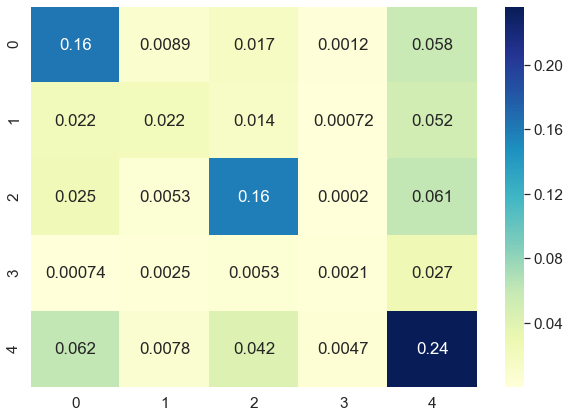

In [26]:
#Plot the confusion matrix
df_cm = pd.DataFrame(average_cm, index = range(5),
                  columns = range(5))
plt.figure(figsize = (10,7))
sns.set(font_scale=1.4)
sns.heatmap(df_cm, annot=True, cmap="YlGnBu")

#### Precision and Recall:

In [27]:
true_pos = np.diag(average_cm)
false_pos = np.sum(average_cm, axis=0) - true_pos
false_neg = np.sum(average_cm, axis=1) - true_pos

#Calculate Precision and Recall of the Model:
precision = (true_pos / (true_pos + false_pos))
recall = (true_pos / (true_pos + false_neg))
acc = np.sum(true_pos)/np.sum(average_cm)

print('Precision: {}'.format(precision))
print('Recall: {}'.format(recall))

Precision: [0.59792818 0.46973679 0.66789854 0.23497794 0.54432581]
Recall: [0.65942921 0.19601522 0.6326868  0.05581505 0.66924523]
